# INTRODUCTION


Author : M Gheddi

Dataset : https://www.kaggle.com/datasets/prajwalbhamere/car-damage-severity-dataset/data

Objective : Using CNN model to classify damage severity on cars.

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D  , MaxPooling2D, Flatten, Dense, Dropout
import pandas as pd
import numpy as np
from tensorflow import keras
import datetime
from tensorflow.keras.applications import ResNet152V2
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import random
import cv2

In [4]:
# Image normalization for faster convergence
def Normalizer(image):
    mean = np.mean(image)
    std = np.std(image)
    normalized_image = (image - mean) / (std + 1e-7)  # Adding a small value to avoid division by zero
    return normalized_image

datagen = ImageDataGenerator(
    zca_whitening = True,
    rotation_range = 15,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range=(0.5, 1.5),
    rescale=1./255,  # Rescale pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=Normalizer,
    validation_split=0.2  # Split data into training (80%) and validation (20%)
)

# Define the parameters
batch_size = 32
image_size = (224, 224)
epochs = 10
num_classes = 3  # Number of classes in your dataset

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


In [5]:
# Load and augment the training data
train_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/# DATA SCIENCE/my project/Computer Vision/training',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification and the label is one hot encoded
    subset='training'  # Specify 'training' for the training split
)

# Load and augment the validation data
validation_generator = datagen.flow_from_directory(
    '/content/drive/MyDrive/# DATA SCIENCE/my project/Computer Vision/validation',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify 'validation' for the validation split
)

Found 1132 images belonging to 3 classes.
Found 49 images belonging to 3 classes.


# MODEL DEFINITION

### Transfer Learning Resnet50

VGG16: VGG16 is a strong image classification model but is not as deep as ResNet-50. While it performs well, it may not achieve state-of-the-art accuracy on complex tasks.

ResNet-50: ResNet-50 has been one of the most successful architectures for image classification. Its deep structure and residual connections have allowed it to achieve state-of-the-art performance on various image classification challenges.

In [6]:
ResNet152v2 = ResNet152V2(weights='imagenet', include_top=False)

# keep the earlier layer frozen
for layer in ResNet152v2.layers[:-15]:
    layer.trainable = False

for layer in ResNet152v2.layers[-15:]:
    layer.trainable = True

model = keras.Sequential([
  ResNet152v2,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(1024, activation='relu'),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(3, activation='softmax')
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, None, None, 2048   58331648  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

### Callback

In [7]:
# Define a Callback class that stops training once accuracy reaches 80%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.8):
            print("\nReached 80% accuracy so stopped training.")
            self.model.stop_training = True

callbacks = myCallback()

# MODEL TRAINING

In [8]:
# categorical cross entropy for one hot encoded label, sparse categorical for integer label
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/20
35/35 [==============================] - 48s 783ms/step - loss: 1.0919 - accuracy: 0.4214 - val_loss: 1.3505 - val_accuracy: 0.5000
Epoch 2/20
35/35 [==============================] - 24s 697ms/step - loss: 0.9721 - accuracy: 0.5009 - val_loss: 1.0476 - val_accuracy: 0.6250
Epoch 3/20
35/35 [==============================] - 24s 686ms/step - loss: 0.9282 - accuracy: 0.5591 - val_loss: 1.1350 - val_accuracy: 0.5312
Epoch 4/20
35/35 [==============================] - 26s 727ms/step - loss: 0.9165 - accuracy: 0.5609 - val_loss: 1.1074 - val_accuracy: 0.5625
Epoch 5/20
35/35 [==============================] - 24s 677ms/step - loss: 0.9383 - accuracy: 0.5364 - val_loss: 1.0951 - val_accuracy: 0.4688
Epoch 6/20
35/35 [==============================] - 25s 724ms/step - loss: 0.9299 - accuracy: 0.5482 - val_loss: 0.8854 - val_accuracy: 0.6562
Epoch 7/20
35/35 [==============================] - 25s 723ms/step - loss: 0.8949 - accuracy: 0.5636 - val_loss: 1.2126 - val_accuracy: 0.5000

# MODEL EVALUATION

## Visual Inspection

In [25]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
import matplotlib.pyplot as plt

# Define directories where images are stored
directories = ['/content/drive/MyDrive/# DATA SCIENCE/my project/Computer Vision/validation/01-minor',
               '/content/drive/MyDrive/# DATA SCIENCE/my project/Computer Vision/validation/02-moderate',
               '/content/drive/MyDrive/# DATA SCIENCE/my project/Computer Vision/validation/03-severe']

class_names = ['Minor Damage', 'Moderate Damage', 'Severe Damage']

# Create a grid for displaying images
rows, cols = 3, 5
fig, axes = plt.subplots(rows, cols, figsize=(120, 48))

for i, directory in enumerate(directories):
    # Get a list of image files in the directory
    files = os.listdir(directory)
    sample_files = np.random.choice(files, 5, replace=False)

    for j, filename in enumerate(sample_files):
        img_path = os.path.join(directory, filename)

        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)

        # Make predictions
        preds = model.predict(img)
        predicted_class_index = np.argmax(preds)
        predicted_class = class_names[predicted_class_index]

        # Display the image and its predicted label
        ax = axes[i][j]
        ax.imshow(image.load_img(img_path))
        ax.set_title(f'Predicted: {predicted_class}', fontsize=72)
        fontsize=12
        ax.axis('off')

# Hide any remaining empty subplots
for i in range(len(directories), rows):
    for j in range(3, cols):
        axes[i][j].axis('off')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 30ms/step


## Confusion Matrix

<ipython-input-17-5cf7f083cccd>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(train_generator)
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


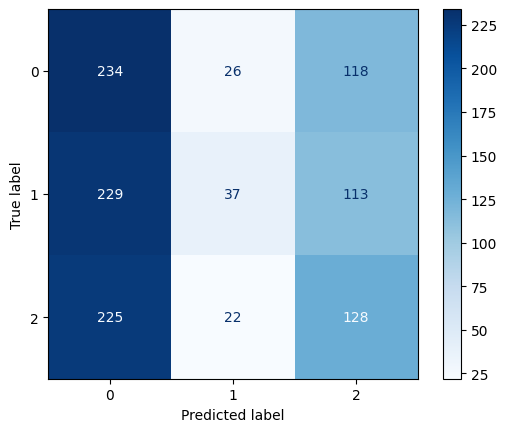

In [17]:
true_labels = train_generator.classes
predictions = model.predict_generator(train_generator)

# Get the class indices with the highest predicted probabilities
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion)
disp.plot(cmap=plt.cm.Blues)
plt.show()

<ipython-input-19-beb38ace5b36>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator)
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


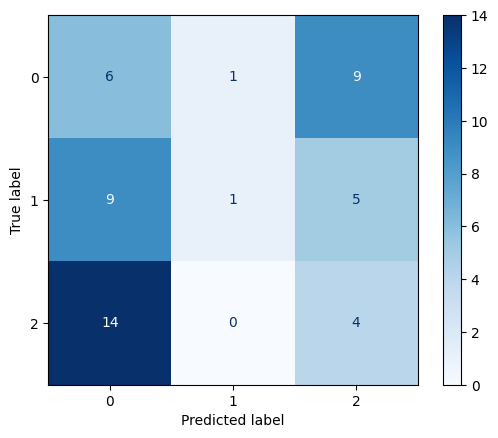

In [19]:
true_labels = validation_generator.classes
predictions = model.predict_generator(validation_generator)

# Get the class indices with the highest predicted probabilities
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Classification Report

In [21]:
# Calculate the classification report
class_names = list(train_generator.class_indices.keys())  # Get the class names
true_labels = train_generator.classes
predictions = model.predict_generator(train_generator)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report for Train Set:")
print(report)

<ipython-input-21-1202de0eb8e1>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(train_generator)
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Classification Report for Train Set:
              precision    recall  f1-score   support

    01-minor       0.35      0.62      0.45       378
 02-moderate       0.34      0.05      0.09       379
   03-severe       0.33      0.35      0.34       375

    accuracy                           0.34      1132
   macro avg       0.34      0.34      0.29      1132
weighted avg       0.34      0.34      0.29      1132



In [22]:
# Calculate the classification report
class_names = list(validation_generator.class_indices.keys())  # Get the class names
true_labels = validation_generator.classes
predictions = model.predict_generator(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report for Validation Set:")
print(report)

<ipython-input-22-6933ab45bc9c>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(validation_generator)
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1884: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Classification Report for Validation Set:
              precision    recall  f1-score   support

    01-minor       0.41      0.81      0.54        16
 02-moderate       0.60      0.20      0.30        15
   03-severe       0.25      0.17      0.20        18

    accuracy                           0.39        49
   macro avg       0.42      0.39      0.35        49
weighted avg       0.41      0.39      0.34        49



# MODEL SAVING

In [26]:
model.save("auto_defect_detection.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
